# TEST DATALOADER 2D DISCRETE

In [1]:
from operator import itemgetter

import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
import fiona

import matplotlib
import matplotlib.pyplot as plt

from rasterio.enums import Resampling
import xarray

from geocube.api.core import make_geocube
from shapely.geometry import box

In [2]:
xr = xarray.open_dataset("/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc")
xr = xr.rio.write_crs("epsg:4326")

In [3]:
d1 = xr["time"][0]
d2 = xr["time"][10]

In [4]:
d2.values

np.datetime64('1958-09-10T00:00:00.000000000')

In [5]:
xr_xr = xr.sel(time=slice(d1, d2))

In [6]:
xr_xr.to_array().shape

(10, 11, 9, 12)

In [7]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

class DiscreteDataset(Dataset):
    """Precipitations-TemperatureMin-TemperatureMax dataset."""

    def __init__(self, dict_files, transform=None):
        """
        Args:
            dict_files (string): Path to the .nc file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.dict_files = dict_files
        self.timesteps = self.dict_files["timesteps"]

        self.loading_weather()

        self.loading_rasterized_wtd()

        self.transform = transform

    def loading_weather(self):
        self.weather_xr = xarray.open_dataset(self.dict_files["weather_nc_path"])
        self.weather_xr = self.weather_xr.rio.write_crs("epsg:4326")

    def loading_rasterized_wtd(self):
        wtd_df = pd.read_csv(self.dict_files["wtd_csv_path"], dtype= {"sensor_id": "str"})
        wtd_df = wtd_df.astype({"date":'datetime64[ns]'})

        wtd_names  = gpd.read_file(self.dict_files["wtd_shp"], engine='fiona')
        wtd_names = wtd_names.to_crs('epsg:4326')

        dtm_roi = rioxarray.open_rasterio(self.dict_files["dtm_nc"], engine='fiona')
        dtm_roi = dtm_roi.rio.write_crs("epsg:4326")

        all_dates = wtd_df["date"].unique()
        sensor_id_list = wtd_df["sensor_id"].unique()
        
        # add coordinates to wtd values
        sensor_coord_x_list = []
        sensor_coord_y_list = []
        for sensor in sensor_id_list:
            coord_x = wtd_names.loc[wtd_names["sensor_id"] == sensor].geometry.x.values[0]
            coord_y = wtd_names.loc[wtd_names["sensor_id"] == sensor].geometry.y.values[0]
            sensor_coord_x_list.append(coord_x)
            sensor_coord_y_list.append(coord_y)

        from_id_to_coord_x_dict = {sensor_id_list[i]: sensor_coord_x_list[i] for i in range(len(sensor_coord_x_list))}
        from_id_to_coord_y_dict = {sensor_id_list[i]: sensor_coord_y_list[i] for i in range(len(sensor_coord_y_list))}

        queries = list(wtd_df["sensor_id"].values)
        coordinates_x = itemgetter(*queries)(from_id_to_coord_x_dict)
        coordinates_y = itemgetter(*queries)(from_id_to_coord_y_dict)

        wtd_df["x"] = coordinates_x
        wtd_df["y"] = coordinates_y

        # downscaling dtm
        downscale_factor = 0.1
        new_width = int(dtm_roi.rio.width * downscale_factor)
        new_height = int(dtm_roi.rio.height * downscale_factor)

        self.dtm_roi_downsampled = dtm_roi.rio.reproject(
            dtm_roi.rio.crs,
            shape=(new_height, new_width),
            resampling=Resampling.bilinear,
        )

        wtd_data_geop = gpd.GeoDataFrame(
        wtd_df, geometry=gpd.points_from_xy(wtd_df["x"], 
                                            wtd_df["y"]), crs="EPSG:4326")
        wtd_data_geop = wtd_data_geop[["date","wtd","geometry"]]

        self.minx = self.dtm_roi_downsampled.x.min()
        self.miny = self.dtm_roi_downsampled.y.min()
        self.maxx = self.dtm_roi_downsampled.x.max()
        self.maxy = self.dtm_roi_downsampled.y.max()
        
        rasterized_ds_list = []
        for date_idx in range(len(all_dates)):
            
            vector_ds = wtd_data_geop.loc[wtd_data_geop["date"] == all_dates[date_idx],:]

            rasterized_ds = make_geocube(vector_data=vector_ds,
                                        measurements=['wtd'],
                                        output_crs="epsg:4326",
                                        resolution=(self.dtm_roi_downsampled.rio.transform().a, self.dtm_roi_downsampled.rio.transform().e),
                                        # Global extent in degrees of longitude and latitude
                                        geom=box(minx=self.minx, miny=self.miny, maxx=self.maxx, maxy=self.maxy))
            
            rasterized_ds_list.append(rasterized_ds)

        self.wtd_data_raserized = xarray.concat(rasterized_ds_list, dim = "time")
        self.wtd_data_raserized = self.wtd_data_raserized.assign_coords({"time": all_dates})

        self.wtd_data_raserized = self.wtd_data_raserized.reindex(y=list(reversed(self.wtd_data_raserized.y)))
        self.wtd_data_raserized = self.wtd_data_raserized.reindex(x=list(reversed(self.wtd_data_raserized.x)))

    def __len__(self):
        return len(self.wtd_data_raserized["wtd"]) - self.timesteps
    
    def __getitem__(self, idx):
        """"
        Input: (wtd_t, weather_t-T,t)
        Output: (wtd_t+1:t+T+1)        
        """
        if idx < 0:
            idx = self.__len__() + idx

        input_wtd = self.wtd_data_raserized["wtd"][idx].to_numpy()
        input_wtd_mask = np.ones_like(input_wtd) - np.isnan(input_wtd)
        input_wtd = np.stack((input_wtd, input_wtd_mask), axis=-1)

        d1 = self.wtd_data_raserized["time"][idx+1]
        d2 = self.wtd_data_raserized["time"][idx+self.timesteps]
        input_weather = self.weather_xr.sel(time=slice(d1, d2)).to_array().values

        output_wtd = self.wtd_data_raserized["wtd"][idx+1:idx+1+self.timesteps].to_numpy()
        output_wtd_mask = np.ones_like(output_wtd) - np.isnan(output_wtd)
        output_wtd = np.stack((output_wtd, output_wtd_mask), axis=-1)

        if self.transform:
            sample = self.transform(sample)

        return torch.from_numpy(input_wtd), torch.from_numpy(input_weather), torch.from_numpy(output_wtd)

In [8]:
dict_files = {
    "wtd_csv_path" : "/leonardo_work/IscrC_DL4EO/trials/data/dataset_wtd_roi.csv",
    "weather_nc_path" : "/leonardo_work/IscrC_DL4EO/trials/data/meteo_bucket_model_snowpack_ROI_1958_2023.nc",
    "wtd_shp" : "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/underground_wtd_sensor_roi.shp",
    "piedmont_shp" : "/leonardo_work/IscrC_DL4EO/trials/data/shapefile/piemonte_admin_boundaries.shp",
    "dtm_nc" : "/leonardo_work/IscrC_DL4EO/trials/data/dtm_ROI.nc",
    "timesteps" : 90
}

ds = DiscreteDataset(dict_files)

In [9]:
print(f"Length of the dataset: {ds.__len__()}")

Length of the dataset: 10137


In [10]:
print(f"Item -1: {ds[-1]}")

Item -1: (tensor([[[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]],

        [[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]],

        [[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]],

        ...,

        [[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]],

        [[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]],

        [[nan, 0.],
         [nan, 0.],
         [nan, 0.],
         ...,
         [nan, 0.],
         [nan, 0.],
         [nan, 0.]]], dtype=torch.float64), tensor([[[[ 5.7007e-02,  4.9011e-02,  3.4973e-02,  ...,  5.0049e-03,
            1.0010e-02,  2.6978e-02],
          [ 3.1006e-02,  1.7029

In [11]:
x,y,z = ds[-1]
print(f"Sizes: {x.shape} - {y.shape} - {z.shape}")

Sizes: torch.Size([114, 167, 2]) - torch.Size([10, 90, 9, 12]) - torch.Size([90, 114, 167, 2])


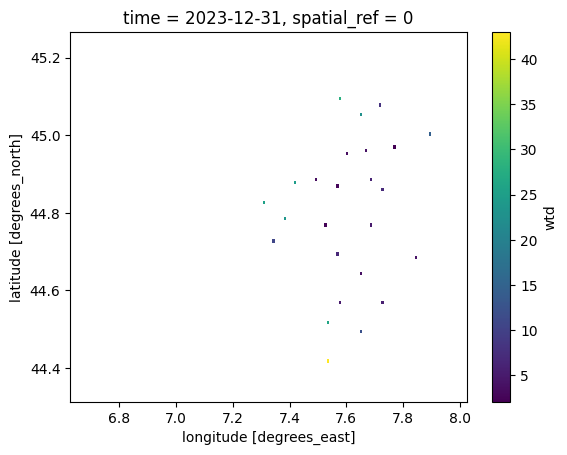

In [12]:
ds.wtd_data_raserized["wtd"][-1].plot()

In [13]:
ds.wtd_data_raserized["wtd"][-1]

<xarray.DataArray 'wtd' (y: 114, x: 167)> Size: 152kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * y            (y) float64 912B 45.26 45.25 45.24 45.24 ... 44.33 44.33 44.32
  * x            (x) float64 1kB 6.631 6.639 6.647 6.656 ... 8.004 8.013 8.021
    time         datetime64[ns] 8B 2023-12-31
    spatial_ref  int64 8B 0
Attributes:
    name:        wtd
    long_name:   wtd
    _FillValue:  nan

In [14]:
ds.dtm_roi_downsampled

<xarray.DataArray '__xarray_dataarray_variable__' (band: 1, y: 114, x: 168)> Size: 77kB
array([[[2899.5454 , 2800.0447 , 2652.8933 , ...,  207.18225,
          203.91689,  200.8909 ],
        [2745.5928 , 2573.3943 , 2378.1335 , ...,  201.14403,
          197.62209,  194.39249],
        [2582.547  , 2200.7563 , 2236.475  , ...,  196.59752,
          194.13895,  190.74823],
        ...,
        [1816.2076 , 2051.5916 , 2158.6135 , ...,  829.5154 ,
          808.9886 ,  741.43695],
        [1769.3004 , 1817.0792 , 1762.4233 , ...,  840.6071 ,
          823.92474,  812.00555],
        [1609.5911 , 1636.23   , 1672.0851 , ...,  833.7745 ,
          827.46497,  753.8922 ]]], dtype=float32)
Coordinates:
  * x            (x) float64 1kB 6.63 6.639 6.647 6.655 ... 8.009 8.017 8.025
  * y            (y) float64 912B 45.26 45.25 45.24 45.24 ... 44.33 44.32 44.31
  * band         (band) int64 8B 1
    spatial_ref  int64 8B 0
Attributes:
    NETCDF_DIM_EXTRA:  {band}
    AREA_OR_POINT:     Area
    scale_factor:      1.0
    add_offset:        0.0
    NETCDF_DIM_band:   1
    _FillValue:        nan

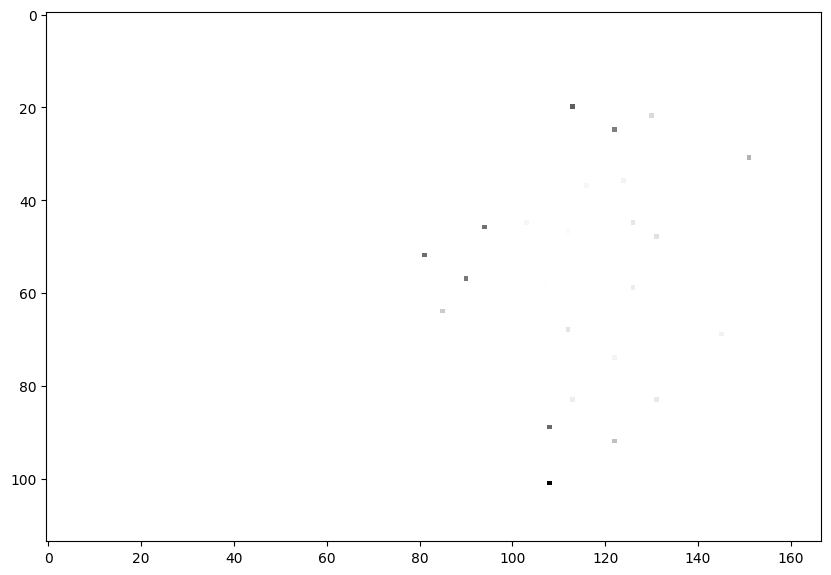

In [15]:
plt.figure(figsize = (10,10))
plt.imshow(ds.wtd_data_raserized["wtd"][-1].values, cmap="binary")

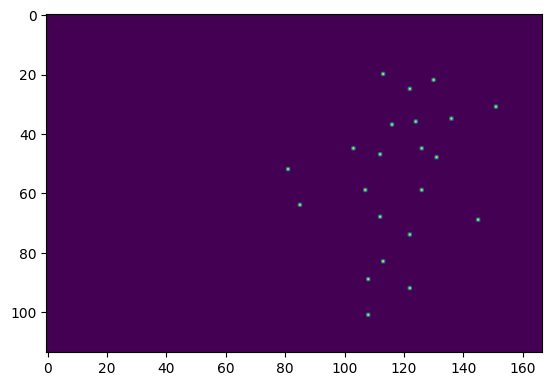

In [16]:
plt.imshow(x[:,:,1])

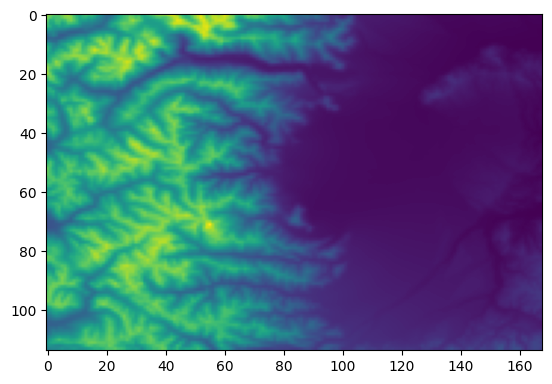

In [17]:
plt.imshow(ds.dtm_roi_downsampled[-1].values)

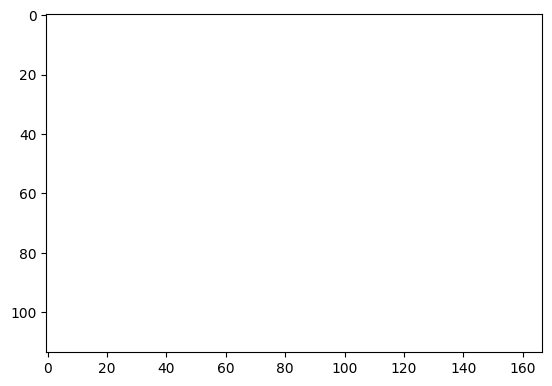

In [18]:
plt.imshow(ds.wtd_data_raserized["wtd"][-90])

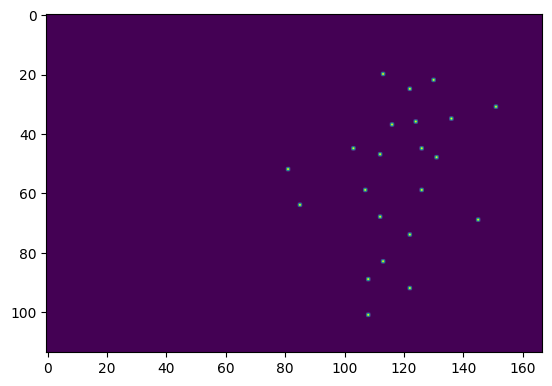

In [19]:
plt.imshow(x[:,:,0] == ds.wtd_data_raserized["wtd"][-91])

In [20]:
input_mask_p = 0.1
output_mask_p = 0.1

nonzero_idxs = np.nonzero(x[:,:,1])
input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m

/scratch_local/ipykernel_4048995/1532092383.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x[nonzero_idxs[:,0],nonzero_idxs[:,1],0] * input_mask_m


tensor([27.2100,  8.1195, 22.5753, 14.3167,  2.0300,  4.1033,  3.5700,  4.2433,
         6.3600,  3.1053,  7.3213, 25.4000,  2.4100,  5.2200, 10.6167,  5.6723,
         4.0000,  4.0600,  5.6700, 26.3783,  0.0000, 40.7867],
       dtype=torch.float64)

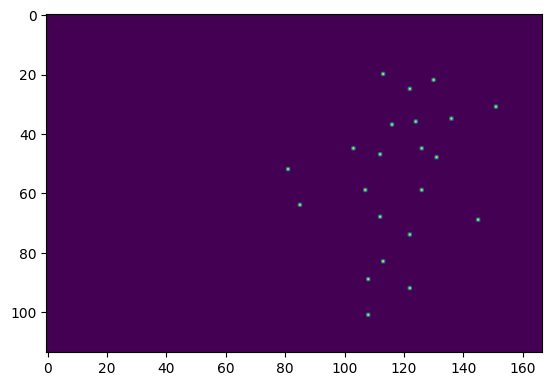

In [21]:
plt.imshow(x[:,:,1])

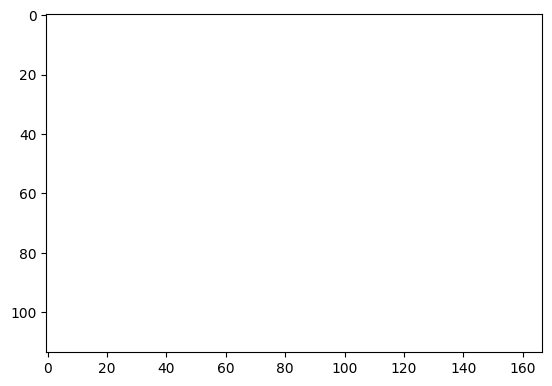

In [22]:
plt.imshow(z[-1,:,:,0])

In [23]:
ds.wtd_data_raserized["wtd"].shape

(10227, 114, 167)

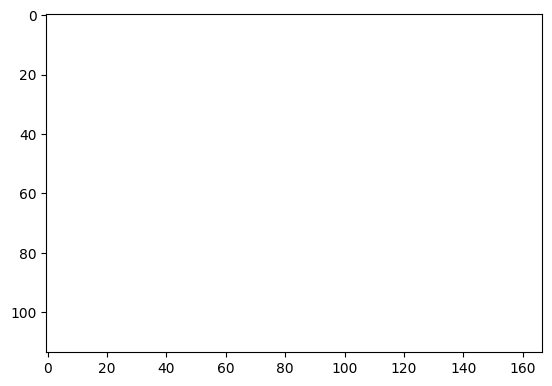

In [24]:
plt.imshow(ds.wtd_data_raserized["wtd"][-1,:,:])

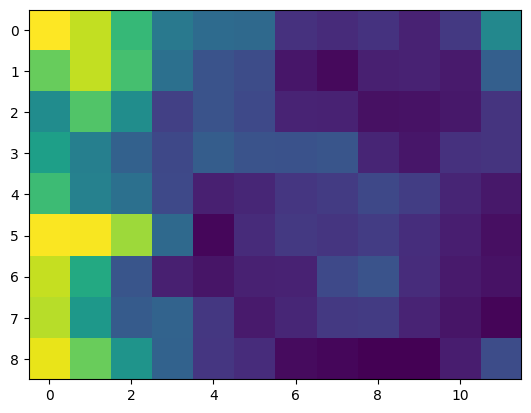

In [25]:
plt.imshow(ds.weather_xr["prec"][-1])

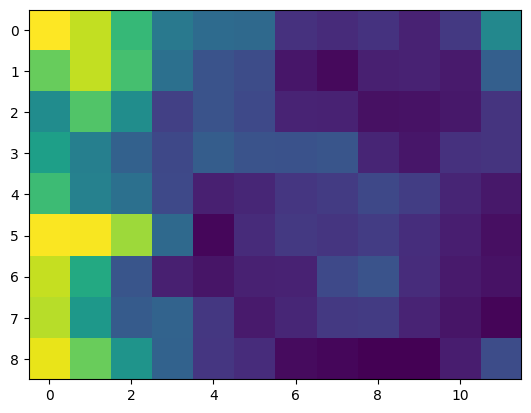

In [26]:
plt.imshow(y[0,-1,:,:])

# TEST DATALOADER

In [27]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [28]:
class Discrete2DNN(nn.Module):
    def __init__(self, num_layers = 1):
        super().__init__()
        
        # processing initial values
        # self.conv1_init = nn.Conv2d(1, 20, 3) # ch_in, ch_out, kernel

        # transpose conv (upsampling weather)
        self.conv1_w = nn.ConvTranspose3d(10, 10, (1,2,2), stride=(1,2,2), dtype=torch.float64)
        self.conv2_w = nn.ConvTranspose3d(10, 10, (1,2,2), stride=(1,2,2), dtype=torch.float64)
        self.conv3_w = nn.ConvTranspose3d(10, 10, (1,2,2), stride=(1,2,2), dtype=torch.float64)
        self.conv4_w = nn.ConvTranspose3d(10, 10, (1,2,2), stride=(1,2,2), dtype=torch.float64)
        self.avg_pool_5 = nn.AdaptiveAvgPool3d((None, 114, 167))

        self.conv_6 = nn.Conv3d(11, 1, 1, stride=1, dtype=torch.float64)


    def forward(self, x):
        """
        return 
            lstm_out (array): lstm_out = [S_we, M, P_r, Es, K_s, K_r]
        x: tensor of shape (L,Hin) if minibatches itaration (L,N,Hin) when batch_first=False (default)
        """
        (x_init, x_weather) = x 

        # processing initial values x
        # x_init = F.relu(self.conv1_init(x_init))

        # processing weaterh
        x_weather = F.relu(self.conv1_w(x_weather))
        x_weather = F.relu(self.conv2_w(x_weather))
        x_weather = F.relu(self.conv3_w(x_weather))
        x_weather = F.relu(self.conv4_w(x_weather))
        x_weather = F.relu(self.avg_pool_5(x_weather))

        # concat
        x = torch.concat([x_init, x_weather], dim=1)

        out = F.relu(self.conv_6(x))
        
        return out

model = Discrete2DNN().to(device)

In [29]:
input = torch.randn(1,10,90, 9, 12)
m = nn.ConvTranspose3d(10, 10, (1,2,2), stride=(1,2,2))
m2 = nn.AdaptiveAvgPool3d((None, 114, 167))
output = m(input)
output = m(output)
output = m(output)
output = m(output)
output = m2(output)


output.size()

torch.Size([1, 10, 90, 114, 167])

In [30]:
input1 = torch.randn(1, 1, 1, 114, 167)
input1 = input1.repeat(1,1,90,1,1)
print(input1.size())
out2 = torch.concat([input1, output], dim=1)
out2.size()

torch.Size([1, 1, 90, 114, 167])


torch.Size([1, 11, 90, 114, 167])

In [31]:
# [90, 114, 167, 2]
m3 = nn.Conv3d(11, 1, 1, stride=1)
out3 = m3(out2)
out3.size()

torch.Size([1, 1, 90, 114, 167])

# TEST DATALOADER

In [32]:
from torch.utils.data.sampler import SubsetRandomSampler

In [33]:
batch_size = 100
max_epochs = 1

test_split_p = 0.2
train_split_p = 1 - test_split_p
train_idx = int(ds.__len__()*train_split_p)
test_idx = int(ds.__len__()*test_split_p)

train_idxs, test_idxs = np.arange(train_idx), np.arange(train_idx, train_idx + test_idx)

train_sampler = SubsetRandomSampler(train_idxs)
test_sampler = SubsetRandomSampler(test_idxs)

train_loader = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=batch_size,
                                            sampler=train_sampler)

In [ ]:
input_mask_p = 0.2
output_mask_p = 0.1

def apply_mask(x):
    nonzero_idxs = np.nonzero(x[:,:,:,1])
    input_mask_m = np.random.uniform(0,1,len(nonzero_idxs)) > input_mask_p
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],0] * input_mask_m
    x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] = x[nonzero_idxs[:,0],nonzero_idxs[:,1],nonzero_idxs[:,2],1] * input_mask_m

In [35]:
# from tqdm import tqdm

# X = None
# X_masked = None
# Y = None

# for i in range(max_epochs):
#     with tqdm(train_loader, unit="batch") as tepoch:
#             for batch_idx, (init_wtd, weather, pred_wtds) in enumerate(tepoch):
#                 tepoch.set_description(f"Epoch {i}")

#                 # masking input [future]
#                 # X = np.copy(init_wtd)
#                 # apply_mask(init_wtd)
#                 # X_masked = init_wtd
#                 # print(init_wtd[0,:,:,1])
#                 # print(X[0,:,:,1])

#                 X = (init_wtd.to(device), weather.to(device))
#                 Y = model(X)
#                 print(Y.shape)
#                 break

In [36]:
plt.imshow(X[0,:,:,1])

NameError: name 'X' is not defined

In [ ]:
plt.imshow(X_masked[0,:,:,1])

In [66]:
x1,y1,z1 = ds[-1]
print(f"Sizes: {x1.shape} - {y1.shape} - {z1.shape}")

Sizes: torch.Size([114, 167, 2]) - torch.Size([10, 90, 9, 12]) - torch.Size([90, 114, 167, 2])


In [70]:
z1.dtype

torch.float64